In [1]:
import torch
import numpy as np
import torch.nn as nn
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("checkpoints/vq_vae_test/losses.csv")

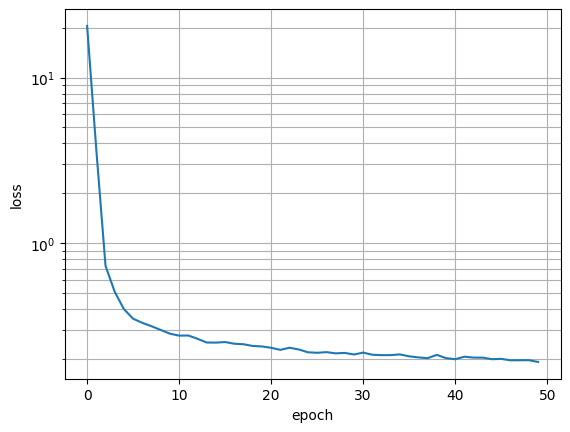

In [13]:
fig, ax = plt.subplots()
ax.plot(range(len(df['loss'])), df['loss'])
ax.set_ylabel("loss")
ax.set_yscale("log")
ax.set_xlabel("epoch")
ax.grid(which = "both")

In [ ]:
kernel_size = 4
stride = 2
kernel_size = kernel_size
# This block here of custom kernels is taken almost directly from the MaskGIT implementation
if kernel_size == 3:
    filter = [1., 2., 1.]
elif kernel_size == 4:
    filter = [1., 3., 3., 1.]
elif kernel_size == 5:
    filter = [1., 4., 6., 4., 1.]
elif kernel_size == 6:
    filter = [1., 5., 10., 10., 5., 1.]
elif kernel_size == 7:
    filter = [1., 6., 15., 20., 15., 6., 1.]
else:
    raise ValueError('Only filter_size of 3, 4, 5, 6 or 7 is supported.')

filter = torch.tensor(filter)
filter = torch.outer(filter, filter)
filter /= torch.sum(filter)
# F.conv2d takes: weight – filters of shape (out_channels,in_channels / groups,kH,kW)
filter = torch.reshape(filter, [1, 1, kernel_size, kernel_size])

x = torch.rand([1, 8, 16, 16])
channel_depth = x.shape[1]
depthwise_filter = torch.tile(filter, [channel_depth, 1, 1, 1])
x = torch.nn.functional.conv2d(x,
                        weight = depthwise_filter,
                        stride = stride,
                        groups = channel_depth,
                        padding = 1)

tensor([[[[0.0156, 0.0469, 0.0469, 0.0156],
          [0.0469, 0.1406, 0.1406, 0.0469],
          [0.0469, 0.1406, 0.1406, 0.0469],
          [0.0156, 0.0469, 0.0469, 0.0156]]]])

In [2]:
for i in range(6, 2, -1):
    print(i)

6
5
4
3
